# To do:

 - Figure out how to signal injuries
 - Create model that generates minutes projections
 - Feature engineer a game count column, and optimize how many games you should be taken per dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta
from haversine import haversine

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")
now = str(datetime.now().date())
print(f"Today's date:", now)

Today's date: 2025-12-11


In [2]:
%run ./common_utils.ipynb

# Feature Engineering

In [3]:
import math

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def travel_km_from_row(row):
    prev = row['PrevLocation']
    cur  = row['Location']
    # missing prev => first game => no travel
    if pd.isna(prev) or pd.isna(cur):
        return 0.0
    # same arena => 0
    if prev == cur:
        return 0.0
    # lookup coords
    prev_coords = arenas.get(prev)
    cur_coords  = arenas.get(cur)
    if not prev_coords or not cur_coords:
        # fallback if code not found
        return 0.0
    return haversine_km(prev_coords[0], prev_coords[1], cur_coords[0], cur_coords[1])

In [71]:
def setup_df(df):
    df = df.sort_values(['Player', 'Date'])

    # Encode string cols
    team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
    df["Team"] = team_encoder.transform(df["Team"])
    df["Opp"] = team_encoder.transform(df["Opp"])
    df["Player"] = player_encoder.fit_transform(df["Player"])
    df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
    
    # Location based features
    df["PrevOpp"] = df.groupby("Player")["Opp"].shift(1)
    df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
    df['Location'] = df.apply(lambda r: r['Team'] if r['Team_type'] == 'Home' else r['Opp'], axis=1)
    df['PrevLocation'] = df.groupby('Player')['Location'].shift(1).fillna(31)
    df['travel_km'] = df.apply(travel_km_from_row, axis=1).fillna(0)
    df['travel_hours'] = df['travel_km'] / 800.0      # approximate flight hours
    df['is_long_trip'] = (df['travel_km'] > 1500).astype(int)
    df['same_arena'] = (df['PrevLocation'] == df['Location']).astype(int)

    stat_cols = []
    for stat in categories:
        for col in [f'Off_{stat}', f'Off_L5_{stat}', f'Def_{stat}', f'Def_L5_{stat}']:
            stat_cols.append(col)

    final_cols = ['Date', 'Team', 'Team_type', 'B2B', 'cup_gm', 'pstszn_gm', 'Player', 'Opp', 
                  'DaysLstGm', 'travel_km', 'travel_hours', 'PrevLocation', 'is_long_trip', 'same_arena', 
                  tgt_stat] + stat_cols
    df = df[final_cols].fillna(0)

    return df

In [76]:
tgt_stat = "TPM"

df = pd.DataFrame()
df2 = pd.DataFrame()
for i in [2023, 2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_actuals.csv")
    df = pd.concat([df, df_actuals])

    df_gms = pd.read_csv(f"../tables/{i}/nba_schedule.csv")
    df_gms['Date'] = pd.to_datetime(df_gms.Date)
    df2 = pd.concat([df2, df_gms])

df['Date'] = pd.to_datetime(df.Date)

df = df.drop_duplicates(subset=['Date','Team','Player'])
df['Tms'] = df['game_id'].apply(lambda x: x.split("_")[1:3])
df['WrngTm'] = df.apply(lambda row: 0 if row['Team'] in row['Tms'] else 1, axis=1)
df['WrngOpp'] = df.apply(lambda row: 0 if row['Opp'] in row['Tms'] else 1, axis=1)
df = df[(df.WrngTm == 0) & (df.WrngOpp == 0)]

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()

df2['Date'] = pd.to_datetime(df2.Date)
df_mtch = df2[['Date', 'AwayABV', 'HomeABV', 'AwayB2B', 'HomeB2B', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Home'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Date','Team', 'Opp', 'B2B', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Date','Team', 'Opp', 'B2B', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Away'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Date', 'Team', 'Team_type', 'cup_gm', 'pstszn_gm']]
df = df.merge(df_mtch, on=['Date', 'Team'])

df = setup_df(df)

display(df)

,Date,Team,Team_type,B2B,cup_gm,pstszn_gm,Player,Opp,DaysLstGm,travel_km,travel_hours,PrevLocation,is_long_trip,same_arena,TPM,Off_PTS,Off_L5_PTS,Def_PTS,Def_L5_PTS,Off_AST,Off_L5_AST,Def_AST,Def_L5_AST,Off_REB,Off_L5_REB,Def_REB,Def_L5_REB,Off_PR,Off_L5_PR,Def_PR,Def_L5_PR,Off_PA,Off_L5_PA,Def_PA,Def_L5_PA,Off_RA,Off_L5_RA,Def_RA,Def_L5_RA,Off_PRA,Off_L5_PRA,Def_PRA,Def_L5_PRA,Off_TPM,Off_L5_TPM,Def_TPM,Def_L5_TPM,Off_STL,Off_L5_STL,Def_STL,Def_L5_STL,Off_BLK,Off_L5_BLK,Def_BLK,Def_L5_BLK,Off_STL_BLK,Off_L5_STL_BLK,Def_STL_BLK,Def_L5_STL_BLK
393,2023-10-26,16,0,0,0,0,0,22,0,0.0,0.0,31.0,0,0,0,0.000000,0.000000,5.000000,5.0,0.000000,0.000000,3.000000,3.0,0.000000,0.000000,4.000000,4.0,0.000000,0.000000,9.000000,9.0,0.000000,0.0,8.000000,8.0,0.000000,0.00,7.000000,7.0,0.000000,0.000000,12.000000,12.0,0.000000,0.000000,1.000000,1.0,0.000000,0.0,2.000000,2.0,0.00,0.00,0.000000,0.0,0.000,0.0,2.000000,2.0
981,2023-10-29,16,0,0,0,0,0,0,3,0.0,0.0,22.0,0,0,2,3.500000,3.500000,16.833333,15.4,0.000000,0.000000,3.500000,3.0,0.500000,0.500000,3.500000,3.2,4.000000,4.000000,20.333333,18.6,3.500000,3.5,20.333333,18.4,0.500000,0.50,7.000000,6.2,4.000000,4.000000,23.833333,21.6,1.000000,1.000000,2.500000,2.6,0.000000,0.0,0.833333,1.0,0.00,0.00,0.166667,0.2,0.000,0.0,1.000000,1.2
1216,2023-10-30,16,0,0,0,0,0,15,1,0.0,0.0,0.0,0,0,0,2.333333,2.333333,12.800000,12.8,0.666667,0.666667,3.000000,3.0,0.333333,0.333333,3.800000,3.8,2.666667,2.666667,16.600000,16.6,3.000000,3.0,15.800000,15.8,1.000000,1.00,6.800000,6.8,3.333333,3.333333,19.600000,19.6,0.666667,0.666667,2.400000,2.4,0.000000,0.0,0.800000,0.8,0.00,0.00,1.200000,1.2,0.000,0.0,2.000000,2.0
1613,2023-11-01,16,1,0,0,0,0,27,2,0.0,0.0,15.0,0,0,0,2.250000,2.250000,11.125000,11.4,0.750000,0.750000,2.125000,2.0,0.500000,0.500000,6.375000,6.0,2.750000,2.750000,17.500000,17.4,3.000000,3.0,13.250000,13.4,1.250000,1.25,8.500000,8.0,3.500000,3.500000,19.625000,19.4,0.500000,0.500000,1.875000,2.0,0.000000,0.0,1.125000,1.2,0.00,0.00,0.625000,1.0,0.000,0.0,1.750000,2.2
2132,2023-11-03,16,0,0,1,0,0,19,2,0.0,0.0,27.0,0,0,0,1.800000,1.800000,17.285714,18.2,0.600000,0.600000,3.714286,3.6,0.400000,0.400000,4.571429,3.8,2.200000,2.200000,21.857143,22.0,2.400000,2.4,21.000000,21.8,1.000000,1.00,8.285714,7.4,2.800000,2.800000,25.571429,25.6,0.400000,0.400000,2.000000,2.6,0.000000,0.0,1.285714,1.2,0.00,0.00,0.428571,0.2,0.000,0.0,1.714286,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67312,2025-11-29,18,1,0,0,0,712,9,5,0.0,0.0,3.0,0,0,0,21.777778,20.400000,16.562500,12.8,4.000000,3.800000,2.437500,2.0,6.125000,4.800000,5.625000,5.0,27.222222,25.200000,22.187500,17.8,25.777778,24.2,19.000000,14.8,9.444444,8.60,8.062500,7.0,31.222222,29.000000,24.625000,19.8,0.000000,0.000000,0.000000,0.0,2.285714,1.6,0.875000,0.6,1.25,1.25,0.312500,0.4,2.625,2.2,1.187500,1.0
51314,2025-01-30,14,0,0,0,0,713,10,0,0.0,0.0,31.0,0,0,0,0.000000,0.000000,13.171717,20.4,0.000000,0.000000,2.979798,4.8,0.000000,0.000000,3.818182,6.0,0.000000,0.000000,16.989899,26.4,0.000000,0.0,16.151515,25.2,0.000000,0.00,6.797980,10.8,0.000000,0.000000,19.969697,31.2,0.000000,0.000000,1.818182,1.8,0.000000,0.0,1.010101,1.8,0.00,0.00,0.373737,0.6,0.000,0.0,1.383838,2.4
52032,2025-02-03,14,0,0,0,0,713,26,4,0.0,0.0,10.0,0,0,0,0.000000,0.000000,13.696078,8.8,0.000000,0.000000,3.225490,2.6,0.000000,0.000000,3.833333,3.2,0.000000,0.000000,17.529412,12.0,0.000000,0.0,16.921569,11.4,0.000000,0.00,7.058824,5.8,0.000000,0.000000,20.754902,14.6,0.000000,0.000000,1.970588,0.6,0.000000,0.0,1.147059,0.4,0.00,0.00,0.254902,0.0,0.000,0.0,1.401961,0.4
53057,2025-02-08,14,0,1,0,0,713,20,5,0.0,0.0,26.0,0,0,0,0.000000,0.000000,12.155963,15.2,0.000000,0.000000,2.697248,2.2,0.000000,0.000000,3.954128,5.6,0.000000,0.000000,16.110092,20.8,0.000000,0.0,14.853211,17.4,0.000000,0.00,6.65

# Baseline Model

In [77]:
n = len(df)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))

feature_cols = [col for col in df.columns 
                if col not in ['Date', tgt_stat]]

X_train, y_train = train_df[feature_cols], train_df[tgt_stat]
X_val,   y_val   = val_df[feature_cols],   val_df[tgt_stat]
X_test,  y_test  = test_df[feature_cols],  test_df[tgt_stat]


model = XGBRegressor(
    enable_categorical=True,
    n_estimators=300,    # number of trees
    learning_rate=0.05,  # step size
    max_depth=6,         # complexity
    subsample=0.8,       # row sampling
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Train: 47750 / Validation: 10232 / Test: 10233
RMSE: 0.9514507221785905
MAE: 0.6164138317108154
R²: 0.6134716272354126


,feature,importance,pct
0,Off_L5_TPM,271.525299,0.292274
1,Off_TPM,97.789650,0.397537
2,Def_L5_TPM,72.448906,0.475522
3,Off_L5_PTS,62.318230,0.542602
4,Def_BLK,13.364836,0.556989
5,same_arena,12.618767,0.570572
6,Def_REB,11.177489,0.582603
7,Off_L5_STL_BLK,11.138027,0.594592
8,Off_STL_BLK,10.655759,0.606062
9,Def_L5_PA,10.311924,0.617162


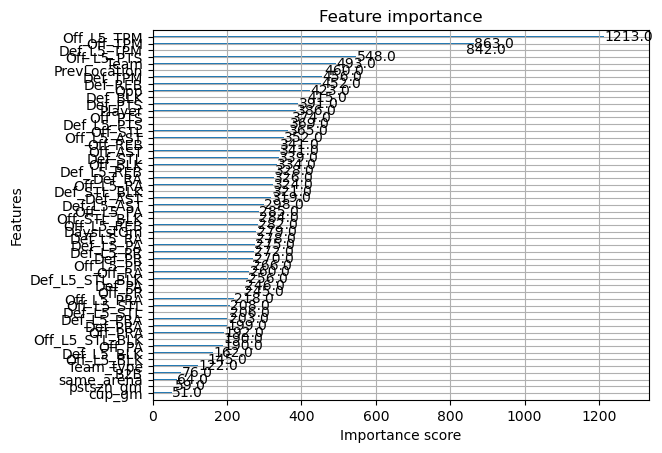

In [78]:
importance = model.get_booster().get_score(importance_type='gain')

# Convert to table
df_importance = (
    pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    })
    .sort_values(by='importance', ascending=False)
    .reset_index(drop=True)
)

df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
display(df_importance[(df_importance.pct <= .85)])

xgb.plot_importance(model)
plt.show()

# Hyperparameter tuning

In [79]:
param_dist = {
    "n_estimators": randint(300, 2000),
    "learning_rate": uniform(0.005, 0.05),
    "max_depth": randint(3, 8),
    "min_child_weight": randint(1, 15),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 10),
    "reg_lambda": uniform(0, 10),
    "reg_alpha": uniform(0, 5),
    "max_leaves": randint(10, 80)
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_, "\n")

preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'colsample_bytree': np.float64(0.9895765921792413), 'gamma': np.float64(6.070342476866847), 'learning_rate': np.float64(0.01879995910112717), 'max_depth': 7, 'max_leaves': 24, 'min_child_weight': 13, 'n_estimators': 364, 'reg_alpha': np.float64(0.07818203370596966), 'reg_lambda': np.float64(4.234014807063696), 'subsample': np.float64(0.8184644554526709)} 

RMSE: 0.9468371179134952
MAE: 0.6104997396469116
R²: 0.617211103439331


In [80]:
pred_col = f'{tgt_stat}_Pred'
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[['Date', 'Team', 'Player', f'{tgt_stat}_line']]
test_df[pred_col] = preds
test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])

df_test = test_df.merge(df_lines, on=['Date', 'Team', 'Player'])
df_test = df_test[[c for c in df_test.columns if c != pred_col] + [pred_col]]

df_test['Diff'] = abs(df_test[f'{tgt_stat}_Pred'] - df_test[f'{tgt_stat}_line'])
df_test['Act_Res'] = np.where(df_test[tgt_stat] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['Pred_Res'] = np.where(df_test[pred_col] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['Correct'] = np.where(df_test['Act_Res'] == df_test['Pred_Res'], 1, 0)

df_test['Diff2'] = abs(df_test[f'{tgt_stat}_Pred'] - df_test[tgt_stat])
df_test['Correct2'] = np.where(df_test['Diff'] <= rmse, 1, 0)

print("Total Accuracy (prediction vs line):", ((df_test.Correct == 1).sum() / df_test.shape[0]))
print((df_test.Correct == 1).sum(), "/", df_test.shape[0])

print("\nTotal Accuracy (prediction vs actual stat):", ((df_test.Correct2 == 1).sum() / df_test.shape[0]))
print((df_test.Correct2 == 1).sum(), "/", df_test.shape[0])

Total Accuracy: 0.5775862068965517
134 / 232

Total Accuracy2: 0.6939655172413793
161 / 232


# Today's predictions

In [81]:
df_pred = pd.read_csv("../tables/2025/parlay_stats.csv")
df_pred['Date'] = pd.to_datetime(df_pred.Date)
for col in df_pred.select_dtypes(include='object').columns:
    df_pred[col] = df_pred[col].astype('category')
df_pred = df_pred.merge(df_mtch, on=['Date', 'Team'])
df_pred[tgt_stat] = 0
df_pred = setup_df(df_pred)
# Filter → then select feature columns
df_pred = df_pred[df_pred.Date == now][feature_cols]

# Predict
df_pred[f"{tgt_stat}_proj"] = best_model.predict(df_pred)
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

for tm in df_pred.Team.unique():
    display(df_pred[(df_pred.Team == tm) & ~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', f'{tgt_stat}_line', f'{tgt_stat}_proj']]\
            .sort_values(f'{tgt_stat}_proj', ascending=False))

,Team,Player,TPM_line,TPM_proj
27,HOU,Kevin Durant,1.5,1.898842
40,HOU,Reed Sheppard,1.5,1.852458
12,HOU,Jabari Smith Jr.,1.5,1.520714
23,HOU,Josh Okogie,0.5,0.958609


,Team,Player,TPM_line,TPM_proj
9,BOS,Derrick White,3.5,4.034490
37,BOS,Payton Pritchard,3.5,2.445774
15,BOS,Jaylen Brown,2.5,2.286583
45,BOS,Sam Hauser,1.5,1.768760
2,BOS,Anfernee Simons,2.5,1.642937


,Team,Player,TPM_line,TPM_proj
28,MIL,Kevin Porter Jr.,2.5,3.576171
34,MIL,Myles Turner,2.5,2.335444
3,MIL,Bobby Portis,1.5,2.086149
43,MIL,Ryan Rollins,2.5,1.834583


,Team,Player,TPM_line,TPM_proj
13,DEN,Jamal Murray,2.5,3.722216
48,DEN,Tim Hardaway Jr.,2.5,2.532691
5,DEN,Cameron Johnson,2.5,1.810568
36,DEN,Nikola Jokic,1.5,1.274845
38,DEN,Peyton Watson,1.5,0.927338


,Team,Player,TPM_line,TPM_proj
32,SAC,Malik Monk,1.5,2.134655
42,SAC,Russell Westbrook,1.5,2.069686
6,SAC,DeMar DeRozan,0.5,1.502964
26,SAC,Keon Ellis,1.5,1.352421
25,SAC,Keegan Murray,2.5,1.199831


,Team,Player,TPM_line,TPM_proj
7,POR,Deni Avdija,1.5,2.790224
16,POR,Jerami Grant,2.5,2.719182
49,POR,Toumani Camara,2.5,2.713737
46,POR,Shaedon Sharpe,1.5,1.921172
30,POR,Kris Murray,0.5,1.325276


,Team,Player,TPM_line,TPM_proj
50,NOP,Trey Murphy III,2.5,2.744168
22,NOP,Jose Alvarado,1.5,2.066993
44,NOP,Saddiq Bey,1.5,1.976014
17,NOP,Jeremiah Fears,0.5,1.698450
10,NOP,Herbert Jones,1.5,1.336871


,Team,Player,TPM_line,TPM_proj
14,LAC,James Harden,2.5,2.216734
24,LAC,Kawhi Leonard,1.5,1.960296
